# MLP WEIGHT OPTIMALISATION WITH EVOLUTIONARY ALGORITHMS

In [3]:
import pandas as pd
import numpy as np
from scipy.special import expit
from matplotlib import pyplot as plt
from sklearn.metrics import f1_score as f1
import math
import random
import operator
import copy
from bisect import bisect
from sklearn.metrics import accuracy_score
np.random.seed(420)

In [4]:
def softmax(x): #https://stackoverflow.com/questions/42599498/numerically-stable-softmax
    x = x-x.max(axis=1).reshape(-1,1) # softmax(x) = softmax(x+c)
    return np.exp(x) / np.exp(x).sum(axis=1).reshape(-1,1)


def softmax_der(x):
    I = np.eye(x.shape[0])
    return softmax(x) * (I - softmax(x).T)


def cross_E(y_true, y_pred):
    return -np.sum(y_true * np.log(y_pred + 10**-10))


def one_hot(x):
    vals = np.unique(x)
    tmp = []
    for val in vals:
        tmp += [((x==val)*1).tolist()]
    return(np.array(tmp))


class MLP():
    def __init__(self, neurons, activation='sigmoid', activation_out='linear', init_weights = 'uniform'):
        self.neurons = neurons
        self.weights = []
        self.biases = []
        self.activation = self.activ[activation]
        self.derivative = self.deriv[activation]
        self.outputActivation = self.activ[activation_out]
        self.outputDerivative = self.deriv[activation_out]
        self.dw_mean = []
        self.db_mean = []
        self.use_softmax = False
        if activation_out == 'softmax':
            self.use_softmax = True

        if init_weights == 'uniform':
            for i in range(len(self.neurons) - 1):
                self.weights += [np.random.uniform(-1, 1, neurons[i]
                                                * neurons[i + 1]).reshape(neurons[i], neurons[i + 1])]
                self.biases += [np.random.uniform(-1, 1,
                                                neurons[i + 1]).reshape(1, neurons[i+1])]
        elif init_weights == 'xavier':
            for i, n in enumerate(self.neurons[:-1]):
                self.weights += [np.random.uniform(-math.sqrt(6) / math.sqrt(neurons[i]), math.sqrt(6) / math.sqrt(neurons[i]), neurons[i]
                                                * neurons[i + 1]).reshape(neurons[i], neurons[i + 1])]
                self.biases += [np.random.uniform(-math.sqrt(6) / math.sqrt(neurons[i]), math.sqrt(6) / math.sqrt(neurons[i]),
                                                neurons[i + 1]).reshape(1, neurons[i+1])]
        
        self.mw = [np.zeros(w.shape) for w in self.weights]  # emthod weights
        self.mb = [np.zeros(b.shape) for b in self.biases]  # method biases

        pass

    activ = {
        'sigmoid': (lambda x: expit(x)),
        'tanh': (lambda x: np.tanh(x)),
        'Relu': (lambda x: np.multiply(x, x > 0)),
        'linear': (lambda x: np.array(x)),
        'softmax': (lambda x: softmax(x))
    }
    deriv = {
        'sigmoid': (lambda x: expit(x)*(1-expit(x))),
        'tanh': (lambda x: 1-np.square(np.tanh(x))),
        'Relu': (lambda x: 1 * (x > 0)),
        'linear': (lambda x: np.ones(x.shape)),
        'softmax':(lambda x: softmax_der(x))
    }
    
    def clear_mw_mb(self):
        self.mw = [np.zeros(w.shape) for w in self.weights]
        self.mb = [np.zeros(b.shape) for b in self.biases]


    def mse(self, y, y_hat):
        return np.square(np.subtract(y, y_hat)).mean()

    def forward(self, x):  # forwardujemy pojednynczy input przez sieć
        self.A = [x]
        self.Z = []

        for layer in range(len(self.neurons)-2):
            net = np.dot(self.A[-1], self.weights[layer]) + self.biases[layer]
            output = self.activation(net)
            self.Z += [net]
            self.A += [output]
        net = np.dot(self.A[-1], self.weights[-1]) + self.biases[-1]
        y_hat = self.outputActivation(net)

        self.Z += [net]
        self.A += [y_hat]

        return y_hat

    def backprop(self, y):
        m = y.shape[0]
        Errors = [None] * len(self.weights)

        Errors[-1] = y - self.A[-1]

        for i in reversed(range(len(Errors)-1)):
            Errors[i] = (np.dot(self.weights[i+1], Errors[i+1].T)
                         * self.derivative(self.Z[i]).T).T

        dw = [None] * len(Errors)
        db = [None] * len(Errors)

        for i, e in enumerate(Errors):
            dw[i] = np.dot(e.T, self.A[i]).T / m
            db[i] = np.dot(e.T, np.ones([m, 1])).T / m

        return (dw, db)

    def learn_batch(self, x, y, iterations=1, batch_size = None, learning_rate=0.001, method='classic', decay=0.4):
        if batch_size is None:
            batch_size = int(math.sqrt(len(x)))
        p = np.random.permutation(len(x))
        x = x[p]
        y = y[p]

        for _ in range(iterations):
            i = 0
            while i < len(x):
                x_batch = x[i: i+batch_size]
                y_batch = y[i: i+batch_size]
                i += batch_size

                self.forward(x_batch)
                (dw, db) = self.backprop(y_batch)

                self.dw_mean += [[np.mean(x) for x in dw]]
                self.db_mean += [[np.mean(x) for x in db]]

                if method == 'classic':
                    for j, w in enumerate(self.weights):
                        self.weights[j] = w + learning_rate*dw[j]
                    for j, b in enumerate(self.biases):
                        self.biases[j] = b + learning_rate*db[j]

                elif method == 'momentum':
                    for j, w in enumerate(self.weights):
                        self.mw[j] = decay * self.mw[j] + dw[j]
                        self.weights[j] = w + learning_rate * self.mw[j]
                    for j, b in enumerate(self.biases):
                        self.mb[j] = decay * self.mb[j] + db[j]
                        self.biases[j] = b + learning_rate*self.mb[j]

                elif method == 'RMSprop':
                    for j, w in enumerate(self.weights):
                        self.mw[j] = decay * self.mw[j] + (1-decay) * np.square(dw[j])
                        self.weights[j] = w + learning_rate * dw[j] / (np.sqrt(self.mw[j]) + 1e-8)
                    for j, b in enumerate(self.biases):
                        self.mb[j] = decay * self.mb[j] + (1-decay) * np.square(db[j])
                        self.biases[j] = b + learning_rate * db[j] / (np.sqrt(self.mb[j]) + 1e-8)

    def classify(self,x):
        probs = self.forward(x)
        return [i.argmax() for i in probs]

In [5]:
def plot_train_test(x_train, y_train, x_test, y_test):
    fig, ax = plt.subplots(1, 2)
    fig.suptitle("Training set vs Test set")
    fig.set_size_inches(12,8)
    ax[0].plot(x_train, y_train, 'o', markersize = 3)
    ax[0].set_title('train')
    ax[1].plot(x_test, y_test, 'o', markersize = 3)
    ax[1].set_title('test')
def plot_test(x_test, y_test, model):
    _, ax = plt.subplots(1,2,figsize = (12,8))
    ax[0].scatter(x_test, y_test)
    ax[1].scatter(x_test, model.forward(x_test))
    ax[0].set_title('test')
    ax[1].set_title('output')
    plt.show()

def mse(y, y_hat):
    return np.square(np.subtract(y, y_hat)).mean()


In [6]:
class EvolutionaryAlgorithm():
    def __init__(self, population_size, neurons, x_train, y_train, metric = 'mse', reproduction_ratio = 0.8, mutation_ratio = 0.2, elitism_ratio = 0.02, activation = 'sigmoid', activation_out = 'linear'):
        self.elitism_ratio = elitism_ratio
        self.neurons = neurons
        self.population_size = population_size
        self.x = x_train
        self.y = y_train
        self.reproduction_ratio = reproduction_ratio
        self.mutation_ratio = mutation_ratio
        if metric == 'mse':
            self.fun = self.mse
        elif metric == 'accuracy':
            self.fun = self.accuracy
        else:
            print('invalid metric')
            return None
        self.population = [MLP(neurons, activation = activation, activation_out = activation_out, init_weights=np.random.choice(['uniform', 'xavier'], 1)) for _ in range(population_size)]
    
    def iterate(self, iterations):
        for _ in range(iterations):
            self.iteration()

    def iteration(self):
        reproducing = self.reproduction()
        crossover_offspring = self.crossover(reproducing)
        mutated_offspring = self.mutation(crossover_offspring)
        self.survival_selection(mutated_offspring + crossover_offspring)

    def reproduction(self):
        fitness_values = np.array(list(map(self.fun, self.population)))
        zip_sorted = sorted(zip(self.population, fitness_values), key = operator.itemgetter(1))
        reproducing = [x for x, _ in zip_sorted[:int(self.reproduction_ratio * self.population_size)]] # best individuals have the lowest score
        return reproducing

    def crossover(self, reproducing):
        num_parents = len(reproducing)
        offspring = []
        random.shuffle(reproducing)
        for i in range(0, num_parents, 2):
            parent1 = reproducing[i]
            if i+1 == len(reproducing):
                parent2 = reproducing[0]
            else:
                parent2 = reproducing[i+1]
            vec1 = weights_to_vec(parent1.weights, parent1.biases)
            vec2 = weights_to_vec(parent2.weights, parent2.biases)
            k = random.randint(1, len(vec1))
            # bools = [int(random.random()>1/2) for _ in vec1]
            # not_bools = [not b for b in bools]
            # child1_vec = np.multiply(vec1, bools) + np.multiply(vec2, not_bools)
            # child2_vec = np.multiply(vec1, not_bools) + np.multiply(vec2, bools)
            child1_vec = vec1[:k] + vec2[k:]
            child2_vec = vec2[:k] + vec1[k:]
            for vec in [child1_vec, child2_vec]:
                (w,b) = vec_to_weights(vec, self.neurons)
                child = MLP(self.neurons)
                child.weights = w
                child.biases = b
                offspring.append(child)
        return offspring
    

    def mutation(self, offspring):
        for child in offspring:
            if random.random()>self.mutation_ratio:
                vec = weights_to_vec(child.weights, child.biases)
                vec += np.random.normal(0,2, len(vec))
                w, b = vec_to_weights(vec, self.neurons)
                child.weights = w
                child.biases = b
                # child.learn_batch(self.x, self.y)
        return offspring
    

    def survival_selection(self, offspring):
        fitness_values = np.array(list(map(self.fun, self.population)))
        offspring_fitness = np.array(list(map(self.fun, offspring)))
        combined_population = self.population + offspring
        combined_fitness = np.concatenate((fitness_values, offspring_fitness))
        

        zip_sorted_parents = sorted(zip(self.population, fitness_values), key = operator.itemgetter(1))
        # elite is only parents
        elite_size = int(self.population_size * self.elitism_ratio)
        elite = [x for x, _ in zip_sorted_parents[:elite_size]]

        # zip_sorted = sorted(zip(combined_population, combined_fitness), key = operator.itemgetter(1))
        # zip_sorted = zip_sorted[int(self.population_size * self.elitism_ratio):]
        zip_sorted_offspring = sorted(zip(offspring, offspring_fitness), key = operator.itemgetter(1))
        selected_offspring = [x for x, _ in zip_sorted_offspring[:self.population_size-elite_size]]
        survivors = elite + selected_offspring

        # survivors = [x for x, _ in zip_sorted[:self.population_size]]
        # probs = np.cumsum(combined_fitness/sum(combined_fitness))
        # survivor_ids = [bisect(probs,el) for el in np.random.uniform(0,1,self.population_size - elite_size)]
        # survivors = [combined_population[i] for i in survivor_ids]
        # survivors += elite
        # survivors = sorted(survivors, key = lambda x: self.fun(x))
        self.population = survivors
        return
    def accuracy(self, model):
        y_hat = model.classify(self.x)
        return -accuracy_score(self.y, y_hat)
    
    def mse(self, model):
        y_hat = model.forward(self.x)
        return np.square(np.subtract(self.y, y_hat)).mean()

    def optimum(self):
        return sorted(self.population, key = lambda x: self.fun(x))[0]
    
def weights_to_vec(weights, biases): # convert from weights and biases matrices to 1D vector
    vec = []
    for w, b in zip(weights, biases):
        w = list(np.ravel(w))
        b = list(np.ravel(b))
        vec+=w
        vec+=b
    return vec
    
def vec_to_weights(vec, neurons): # convert from 1D vector of weights/biases to matrices
    weights = []
    biases = []
    k = 0
    for i in range(len(neurons) - 1):
        w = np.array(vec[k:k+neurons[i] * neurons[i + 1]]).reshape(neurons[i], neurons[i+1])
        k += neurons[i] * neurons[i + 1]
        b = np.array(vec[k:k+neurons[i + 1]]).reshape(1, neurons[i+1])
        k += neurons[i+1]
        weights.append(w)
        biases.append(b)
    return weights, biases



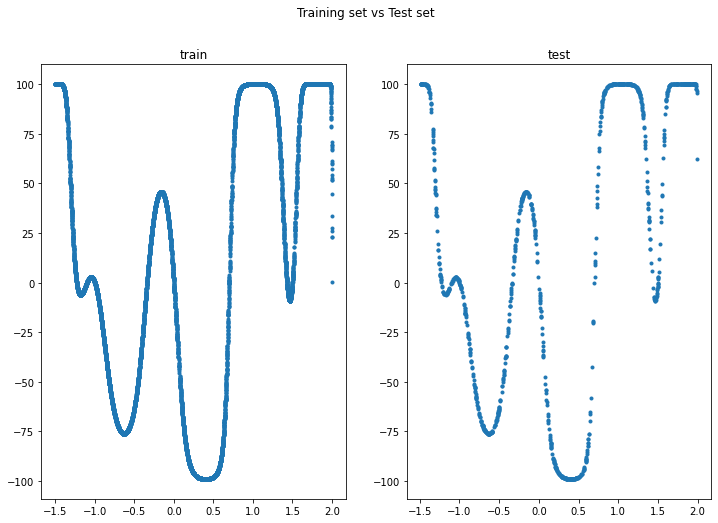

In [7]:
# import multimodal data
train = pd.read_csv('../dane/regression/multimodal-large-training.csv')
x = np.asarray(train['x']).reshape(-1,1)
y = np.asarray(train['y']).reshape(-1,1)
test = pd.read_csv('../dane/regression/multimodal-large-test.csv')
x_test = np.asarray(test['x']).reshape(-1,1)
y_test = np.asarray(test['y']).reshape(-1,1)
plot_train_test(x,y, x_test, y_test)

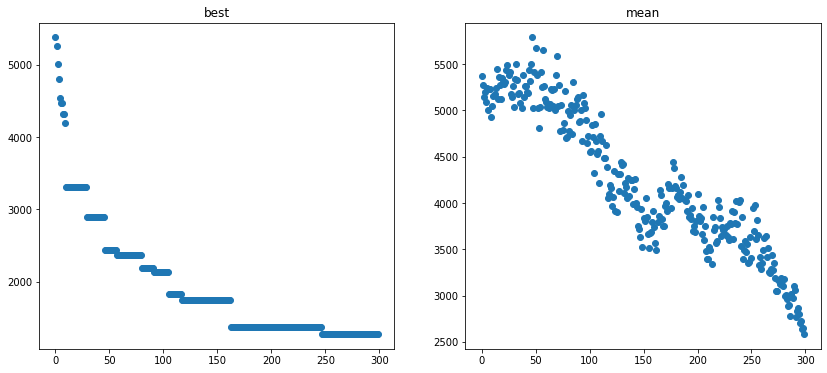

In [6]:
# selection with offspring only (+ elitism)
iterations = 300
fig, ax = plt.subplots(1,2, figsize = (14,6))
alg = EvolutionaryAlgorithm(80, [1,64,64,64, 1], x, y)
best = []
mean = []
for i in range(iterations):
    best.append(alg.mse(alg.population[0]))
    mean.append(np.mean( [alg.mse(i) for i in alg.population] ))
    alg.iterate(1)
ax[0].scatter(np.arange(iterations), best)
ax[1].scatter(np.arange(iterations), mean)
ax[0].set_title('best')
ax[1].set_title('mean')
plt.show()

In [53]:
from sklearn import datasets
from sklearn.metrics import accuracy_score
# import some data to play with
data = datasets.load_iris()['data']
labels = datasets.load_iris()['target']

0.0
0.1
0.2
0.3
0.4
0.5
0.6
0.7
0.8
0.9


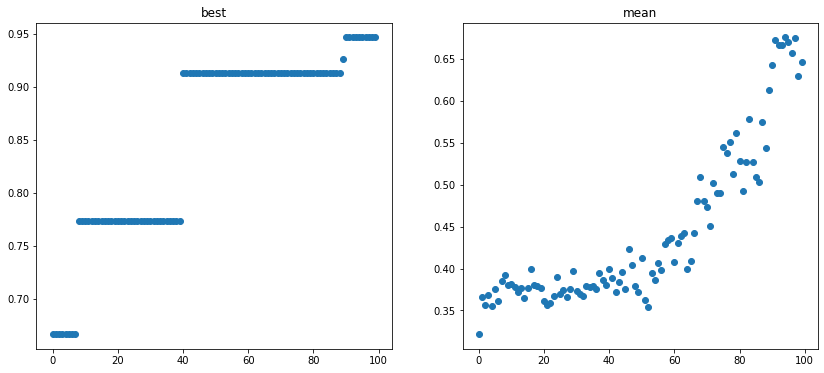

In [34]:
iterations = 100
fig, ax = plt.subplots(1,2, figsize = (14,6))
alg = EvolutionaryAlgorithm(64, [4, 16,16,3], data, labels, activation = 'tanh', activation_out = 'softmax', metric = 'accuracy')
best = []
mean = []
for i in range(iterations):
    scores = [alg.accuracy(i) for i in alg.population]
    best.append(np.max(np.abs(scores)))
    mean.append(np.abs(np.mean(scores)))
    alg.iterate(1)
    if i % 10 == 0:
        print (i/100)
ax[0].scatter(np.arange(iterations), best)
ax[1].scatter(np.arange(iterations), mean)
ax[0].set_title('best')
ax[1].set_title('mean')
plt.show()

In [9]:
df = pd.read_csv('auto-mpg.data', sep='\s+', header=None)
df = df[df[3] != "?"]
y = df.loc[:,0].to_numpy().reshape(-1,1)
y_mean = y.mean()
y_std = y.std()
y = (y-y_mean)/y_std
x = df.loc[:,1:7]
x = x.apply(pd.to_numeric).to_numpy()
x = (x-x.mean(axis = 0))/x.std(axis = 0)

progress at 1.0 %
progress at 2.0 %
progress at 3.0 %
progress at 4.0 %
progress at 5.0 %
progress at 6.0 %
progress at 7.000000000000001 %
progress at 8.0 %
progress at 9.0 %
progress at 10.0 %
progress at 11.0 %
progress at 12.0 %
progress at 13.0 %
progress at 14.000000000000002 %
progress at 15.0 %
progress at 16.0 %
progress at 17.0 %
progress at 18.0 %
progress at 19.0 %
progress at 20.0 %
progress at 21.0 %
progress at 22.0 %
progress at 23.0 %
progress at 24.0 %
progress at 25.0 %
progress at 26.0 %
progress at 27.0 %
progress at 28.000000000000004 %
progress at 28.999999999999996 %
progress at 30.0 %
progress at 31.0 %
progress at 32.0 %
progress at 33.0 %
progress at 34.0 %
progress at 35.0 %
progress at 36.0 %
progress at 37.0 %
progress at 38.0 %
progress at 39.0 %
progress at 40.0 %
progress at 41.0 %
progress at 42.0 %
progress at 43.0 %
progress at 44.0 %
progress at 45.0 %
progress at 46.0 %
progress at 47.0 %
progress at 48.0 %
progress at 49.0 %
progress at 50.0 %
pro

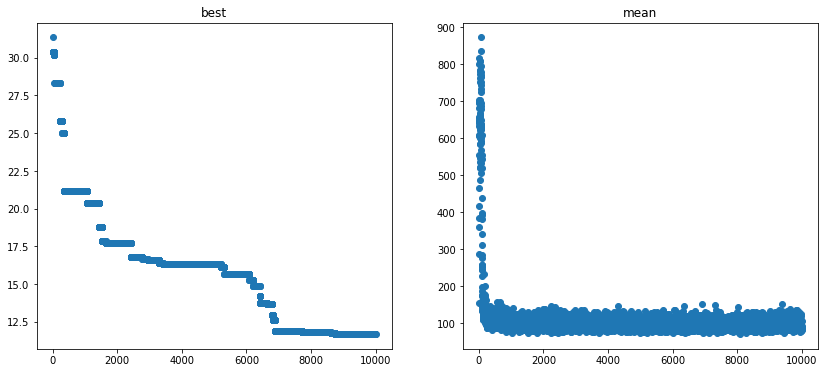

In [279]:
iterations = 10000
fig, ax = plt.subplots(1,2, figsize = (14,6))
alg = EvolutionaryAlgorithm(128, [7, 8, 8, 1], x, y, activation = 'tanh', elitism_ratio= 1/32)
best = []
mean = []
for i in range(iterations):
    scores = [alg.mse(i)*(y_std**2) for i in alg.population]
    best.append(np.min(scores))
    mean.append(np.mean(scores))
    alg.iterate(1)
    if (i+1) % 100 == 0:
        print (f'progress at {(i+1)/iterations*100} %')
ax[0].scatter(np.arange(iterations), best)
ax[1].scatter(np.arange(iterations), mean)
ax[0].set_title('best')
ax[1].set_title('mean')
plt.show()

0.19253698596280372
0.19253698596280372


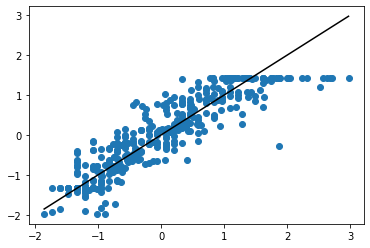

In [309]:
print(alg.mse(alg.population[0]))
# alg.population[0].learn_batch(x, y, 1000, 16, learning_rate= 0.01)
# plt.scatter(y*y_std + y_mean, alg.population[0].forward(x)*y_std + y_mean)
plt.scatter(y, alg.population[0].forward(x))
plt.plot([y.min(), y.max()], [y.min(), y.max()], c = 'black')
print(alg.mse(alg.population[0]))